In [1]:
import xarray as xr
import numpy as np
import os
import json
import gzip
import requests

import matplotlib.pyplot as plt

from functools import partial

from mpl_toolkits.basemap import Basemap

In [29]:
sdap_ds_dict = {}

def sdap_tomo_at_height(height, margin=0.5, b='-120,36.8,-118,37.3'):
    if (height, margin) in sdap_ds_dict:
        print(f'SDAP dict for {height} +/- {margin} already exists')
        return sdap_ds_dict[(height, margin)].copy()
    
    print(f'Fetching SDAP dict for {height} +/- {margin} ')
    
    url = 'http://localhost:8083/datainbounds'
    
    params = {
        'ds': 'Kings_Tomogram_Test_2-temp',
        # ds': 'Kings_Canyon_Tomogram_v2',
        # 'b': '-120,36.8,-118,37.3',
        'b': b,
        'minElevation': height - margin,
        'maxElevation': height + margin,
        'startTime': '2023-04-11T00:31:34Z',
        'endTime': '2023-04-11T00:31:36Z',
        'compact': True
    }
    
    # print('Sending SDAP query')
    response = requests.get(url, params=params)
    # print('Checking response')
    response.raise_for_status()
    
    # print('Loading JSON')
    if response.headers['Content-Type'] == 'application/gzip':
        print('JSON is zipped...')
        var_json = json.loads(gzip.decompress(response.content))
    else:
        var_json = response.json()
        
    print('Loaded JSON')
    
    lats = np.unique([o['latitude'] for o in var_json])
    lons = np.unique([o['longitude'] for o in var_json])
    times = np.unique([o['time'] for o in var_json])

    vals_3d = np.empty((len(times), len(lats), len(lons)))
    
    def get_variables(data):
        variables = {}
        
        for v in data['variables']:
            for name in v:
                variables[name] = v[name]

        return variables
    
    print('Building data dict')
    data_dict = {(data['time'], data['latitude'], data['longitude']): get_variables(data['data'])['tomo'] for data in var_json}
    
    print('Populating value array')
    for i, t in enumerate(times):
        for j, lat in enumerate(lats):
            for k, lon in enumerate(lons):
                vals_3d[i, j, k] = data_dict.get((t, lat, lon), np.nan)
                
    ds = xr.Dataset(
        data_vars=dict(
            tomo=(('time', 'latitude', 'longitue'), vals_3d)
        ),
        coords=dict(
            time=(['time'], times), 
            # Azimuth=(['Azimuth'], azimuths), 
            # Range=(['Range'], ranges),
            latitude=(['latitude'], lats), 
            longitude=(['longitue'], lons),
        ),
        attrs={'margin': margin}
    )
    
    # ds = ds.isel(latitude=slice(None, None, -1))
    
    sdap_ds_dict[(height, margin)] = ds
    
    print('done')
    
    return ds.copy()

In [30]:
ds = {}

def plot_ds(height):
    
    
    data = ds[height]
    margin = data.attrs['margin']
    
    lons = data.longitude.to_numpy().tolist()
    lats = data.latitude.to_numpy().tolist()
    
    def fmt(src, tick_val, tick_pos):
        if int(tick_val) in xs:
            return src[int(tick_val)]
        else:
            return ''
    
    plt.figure(figsize=(15,11))
    plt.imshow(np.squeeze(10*np.log10(data.tomo.to_numpy())), vmax=-10, vmin=-30)
    plt.colorbar(label=f'Tomogram, z={height}m ± {margin} (dB)')
    plt.title(f'Tomogram @ {height}m ± {margin} elevation')
    plt.ylabel('Latitude')
    plt.xlabel('Longitude')
    
    xticks, xlabels = plt.xticks()
    xlabels = [f'{lons[int(t)]:.4f}' if int(t) in range(len(lons)) else '' for t in xticks]
    plt.xticks(xticks, xlabels, rotation=-90)
    
    yticks, ylabels = plt.yticks()
    ylabels = [f'{lats[int(t)]:.4f}' if int(t) in range(len(lats)) else '' for t in yticks]
    plt.yticks(yticks, ylabels,)
    
    plt.savefig(f'King\'s Canyon tomogram @ {height}m elevation.png', facecolor='white')
    plt.show()

In [31]:
ds[100] = sdap_tomo_at_height(100, 0.5)
ds[150] = sdap_tomo_at_height(150)
ds[200] = sdap_tomo_at_height(200, 0.5)
ds[1000] = sdap_tomo_at_height(1000, 0.5)
ds[3000] = sdap_tomo_at_height(3000, 0.5)
ds[3100] = sdap_tomo_at_height(3100, 10)

Fetching SDAP dict for 100 +/- 0.5 
JSON is zipped...
Loaded JSON
Building data dict
Populating value array
done
Fetching SDAP dict for 150 +/- 0.5 
JSON is zipped...
Loaded JSON
Building data dict
Populating value array
done
Fetching SDAP dict for 200 +/- 0.5 
JSON is zipped...
Loaded JSON
Building data dict
Populating value array
done
Fetching SDAP dict for 1000 +/- 0.5 
JSON is zipped...
Loaded JSON
Building data dict
Populating value array
done
Fetching SDAP dict for 3000 +/- 0.5 
JSON is zipped...
Loaded JSON
Building data dict
Populating value array
done
Fetching SDAP dict for 3100 +/- 10 
JSON is zipped...
Loaded JSON
Building data dict
Populating value array
done


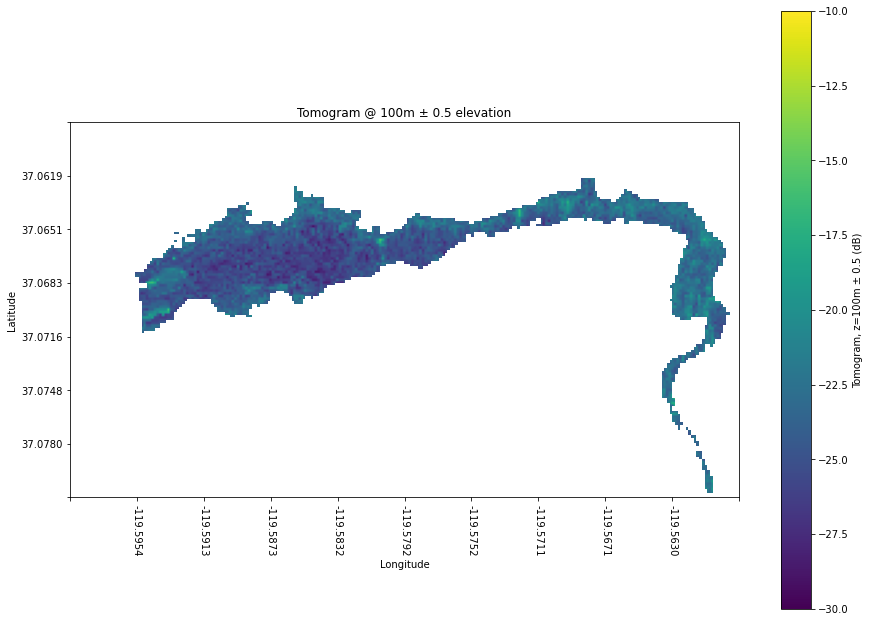

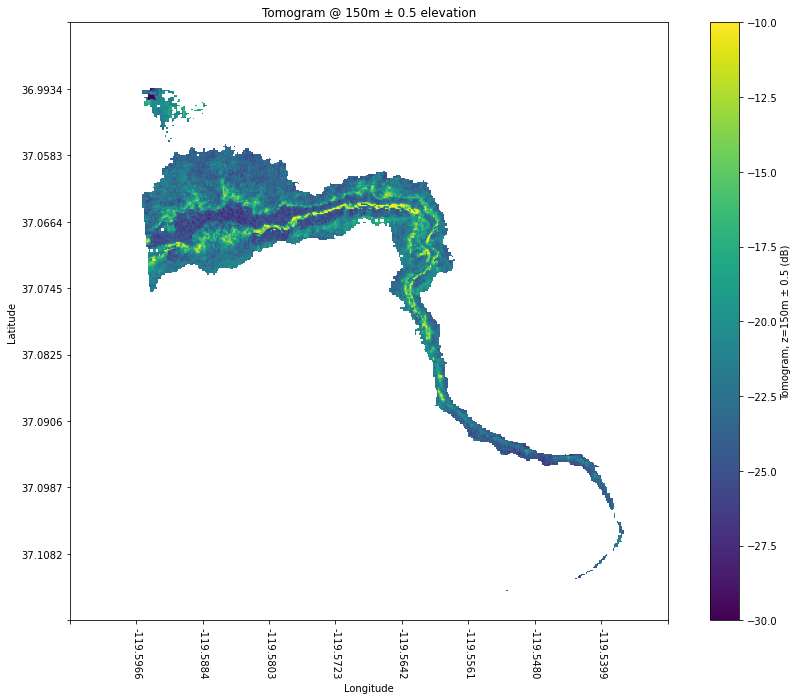

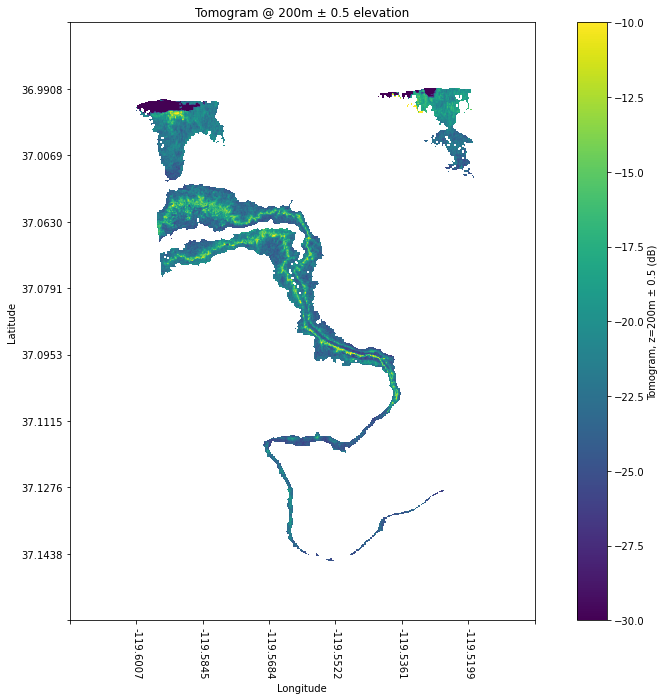

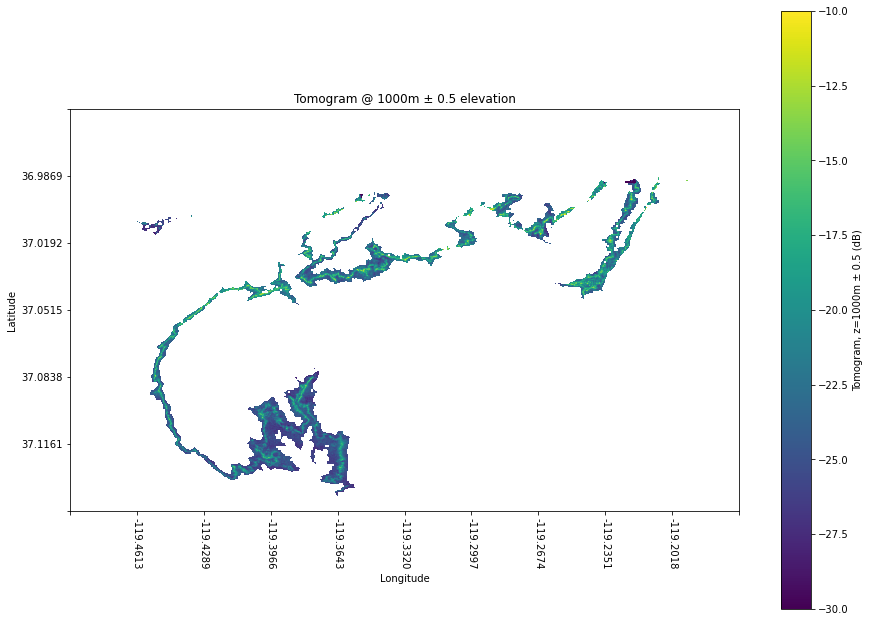

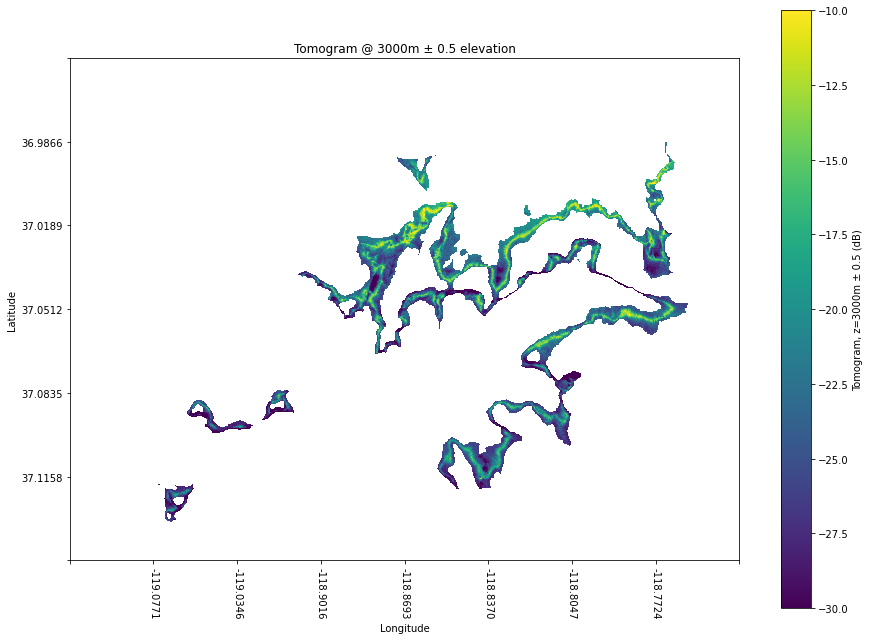

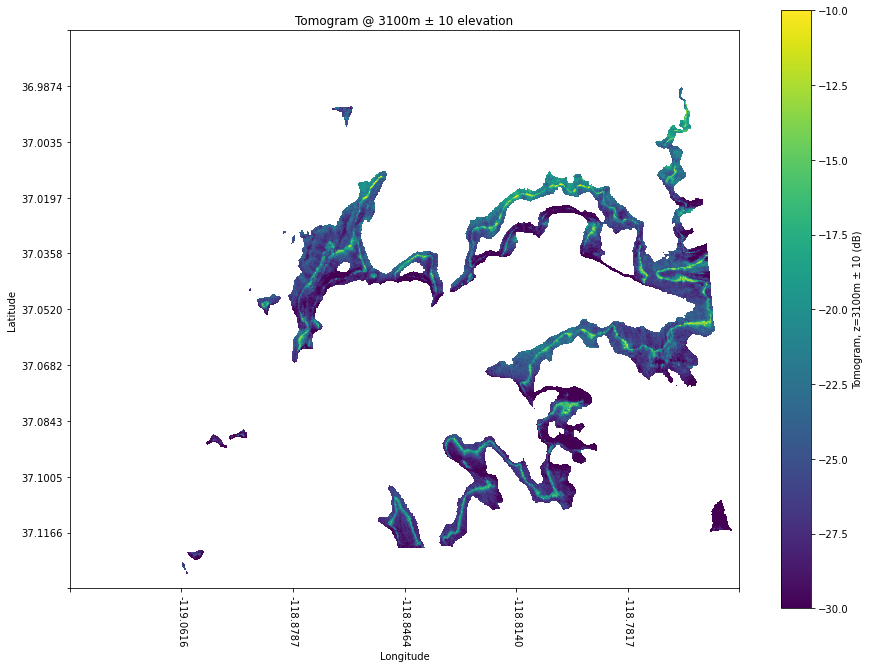

In [32]:
for height in ds:
    if ds[height].tomo.shape == (0,0,0):
        continue
    
    plot_ds(height)

In [26]:
MIN_ELEVATION = 500
MAX_ELEVATION = 1500
STRIDE = 10

slice_ds = {}

for e in range(MIN_ELEVATION, MAX_ELEVATION + 1, STRIDE):
    slice_ds[e] = sdap_tomo_at_height(e, 0.5, b='-119.211,36.8,-119.209,37.3')

SDAP dict for 500 +/- 0.5 already exists
SDAP dict for 510 +/- 0.5 already exists
SDAP dict for 520 +/- 0.5 already exists
SDAP dict for 530 +/- 0.5 already exists
SDAP dict for 540 +/- 0.5 already exists
SDAP dict for 550 +/- 0.5 already exists
SDAP dict for 560 +/- 0.5 already exists
SDAP dict for 570 +/- 0.5 already exists
SDAP dict for 580 +/- 0.5 already exists
SDAP dict for 590 +/- 0.5 already exists
SDAP dict for 600 +/- 0.5 already exists
SDAP dict for 610 +/- 0.5 already exists
SDAP dict for 620 +/- 0.5 already exists
SDAP dict for 630 +/- 0.5 already exists
SDAP dict for 640 +/- 0.5 already exists
SDAP dict for 650 +/- 0.5 already exists
SDAP dict for 660 +/- 0.5 already exists
SDAP dict for 670 +/- 0.5 already exists
SDAP dict for 680 +/- 0.5 already exists
SDAP dict for 690 +/- 0.5 already exists
SDAP dict for 700 +/- 0.5 already exists
SDAP dict for 710 +/- 0.5 already exists
SDAP dict for 720 +/- 0.5 already exists
SDAP dict for 730 +/- 0.5 already exists
SDAP dict for 74

In [28]:
# save
for e in range(MIN_ELEVATION, MAX_ELEVATION + 1, STRIDE):
    print(e)
    slice_ds[e].to_netcdf(f'persist/{e}.nc')


500
510
520
530
540
550
560
570
580
590
600
610
620
630
640
650
660
670
680
690
700
710
720
730
740
750
760
770
780
790
800
810
820
830
840
850
860
870
880
890
900
910
920
930
940
950
960
970
980
990
1000
1010
1020
1030
1040
1050
1060
1070
1080
1090
1100
1110
1120
1130
1140
1150
1160
1170
1180
1190
1200
1210
1220
1230
1240
1250
1260
1270
1280
1290
1300
1310
1320
1330
1340
1350
1360
1370
1380
1390
1400
1410
1420
1430
1440
1450
1460
1470
1480
1490
1500


In [ ]:
# load

slice_ds = {}

for e in range(MIN_ELEVATION, MAX_ELEVATION + 1, STRIDE):
    print(e)
    slice_ds[e] = xr.open_dataset(f'persist/{e}.nc')